<a href="https://colab.research.google.com/github/lovepreetmultani/NLP/blob/main/Spam_Detection_using_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
# import libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping


In [125]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [126]:
messages=pd.read_csv("drive/My Drive/Datasets/SpamData.csv")

In [127]:
messages.head(10)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [128]:
#ps = PorterStemmer()
wordnet = WordNetLemmatizer()

In [129]:
messages = messages.rename(columns={"Category":"label", "Message":"sms"})

In [130]:
messages.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [131]:
messages.describe()

,label,sms
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


In [132]:
messages['length'] = messages['sms'].apply(len)
messages.sort_values(by='length', ascending=False).head(10)

,label,sms,length
1085,ham,For me the love should start with attraction.i...,910
1863,ham,The last thing i ever wanted to do was hurt yo...,790
2434,ham,Indians r poor but India is not a poor country...,629
1579,ham,How to Make a girl Happy? It's not at all diff...,611
2849,ham,Sad story of a Man - Last week was my b'day. M...,588
2158,ham,Sad story of a Man - Last week was my b'day. M...,588
2380,ham,"Good evening Sir, hope you are having a nice d...",482
3017,ham,"&lt;#&gt; is fast approaching. So, Wish u a v...",461
1513,ham,"Hey sweet, I was wondering when you had a mome...",458
5104,ham,A Boy loved a gal. He propsd bt she didnt mind...,446


array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

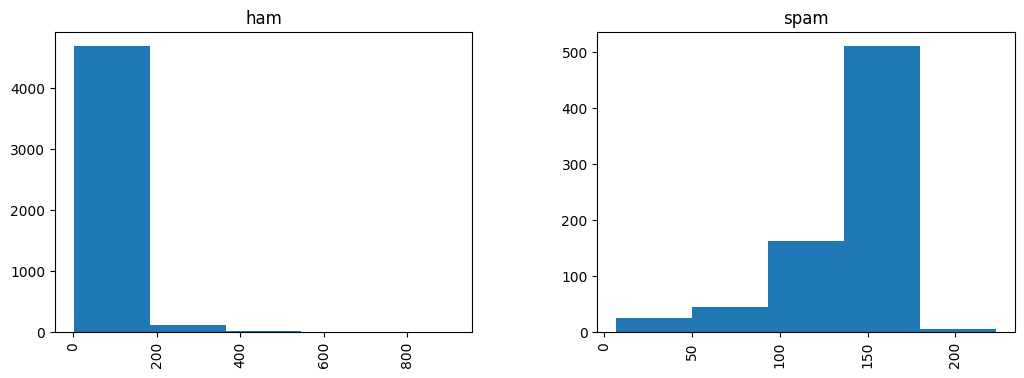

In [133]:
messages.hist(column = 'length', by ='label',figsize=(12,4), bins = 5)

In [134]:
# Get all the ham and spam emails
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']
# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.sms.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.sms.to_numpy().tolist())

In [135]:
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['sms'][i])
    review = review.lower()
    review = review.split()

    review = [wordnet.lemmatize(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [136]:
voc_size=4000
embeding_dim = 16
drop_value = 0.2
n_dense = 24

In [137]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] #one hot is used to convert them into the sequences
onehot_repr

[[1828,
  3086,
  1905,
  3332,
  504,
  3383,
  66,
  3392,
  2632,
  48,
  2939,
  424,
  2351,
  3208,
  2106,
  2487],
 [1255, 2525, 1066, 3154, 3923, 106],
 [2024,
  629,
  2112,
  1290,
  746,
  253,
  1106,
  457,
  619,
  3935,
  3166,
  299,
  253,
  1200,
  629,
  1984,
  1952,
  2521,
  1438,
  418,
  3044],
 [3923, 1156, 2429, 3301, 3122, 3923, 418, 1878, 2429],
 [889, 60, 1828, 3865, 2, 3304, 2305],
 [2722,
  3984,
  321,
  471,
  3573,
  373,
  1046,
  2205,
  1860,
  1,
  1255,
  3657,
  1952,
  3642,
  3755,
  452],
 [393, 1832, 1046, 1295, 1587, 1046, 1895, 3662],
 [3753,
  1750,
  2091,
  2091,
  431,
  2773,
  1565,
  1093,
  1200,
  2955,
  1317,
  1139,
  1756,
  2168,
  2955],
 [2922,
  3988,
  2220,
  2448,
  3405,
  2701,
  3104,
  3369,
  680,
  1749,
  680,
  3599,
  529,
  1643,
  1929],
 [901,
  3486,
  3923,
  1370,
  3208,
  3471,
  3588,
  2221,
  901,
  1841,
  2024,
  1749,
  901,
  3471,
  878,
  2024],
 [678, 1569, 751, 2224, 722, 2334, 1073, 1323, 31

In [138]:
# Sequencing and padding so that each sequence will have same length. Sequencing and padding
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='post',maxlen=sent_length, truncating= "post")
print(embedded_docs)

[[1828 3086 1905 ...    0    0    0]
 [1255 2525 1066 ...    0    0    0]
 [2024  629 2112 ... 2521 1438  418]
 ...
 [ 304  497 1132 ...    0    0    0]
 [3416  915 3372 ...    0    0    0]
 [2449 3812 1745 ...    0    0    0]]


In [139]:
y=messages['label']

In [140]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [141]:
X_final.shape, y_final.shape

((5572, 20), (5572,))

In [142]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.20, random_state = 42)

In [143]:
model=Sequential()
model.add(Embedding(voc_size,embeding_dim,input_length=sent_length))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 20, 16)            64000     
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_10 (Dense)            (None, 24)                408       
                                                                 
 dense_11 (Dense)            (None, 1)                 25        
                                                                 
Total params: 64,433
Trainable params: 64,433
Non-trainable params: 0
_________________________________________________________________
None


In [144]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test),callbacks =[early_stop], verbose=2)

Epoch 1/30


UnimplementedError: ignored

In [149]:
y_pred=model.predict(X_test)

35/35 [==============================] - 0s 2ms/step


In [147]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [148]:
confusion_matrix(y_test,y_pred)
accuracy_score(y_test,y_pred)

ValueError: ignored